## MultiClass Density Maps Benchmark

The Python stack allows visualizing very large datasets but with limited functionality.
This notebook showcases performances issues using the [map of the population density and the racial makeup of the USA](http://www.coopercenter.org/demographics/Racial-Dot-Map).
Each dot in this map corresponds to a specific person counted in the census, located approximately at their residence.
To process the data, we use the [datashader](https://github.com/bokeh/datashader) library, which in turns relies on the
[Dask](http://dask.pydata.org) library to manage very large data, that can be too large to fit in memory.
If you have at least 16GB of RAM, you should be able to run this notebook-as is, using fast in-core operations.  If you have less memory, you'll need to use the slower out-of-core operations by commenting out the ``.persist()`` call.

### Loading data
First, we need to download the dataset. This can take time if you don't have a fast internet access, but you will need to do it only once.
the `data` directory contains the script `load.sh` to load the file and uncompress it.

In [1]:
import datashader as ds
import datashader.transfer_functions as tf
import dask.dataframe as dd
import numpy as np

In [2]:
%%time
df = dd.io.parquet.read_parquet('../data/census.snappy.parq')
df = df.persist()

CPU times: user 22.4 s, sys: 4.15 s, total: 26.5 s
Wall time: 10.6 s


In [3]:
df.head()

,easting,northing,race
0,-13700737.0,6275190.0,w
1,-13700711.0,6275195.0,w
2,-13702081.0,6274898.5,w
3,-13701948.0,6274931.0,w
4,-13701793.0,6275088.5,w


There are 306675004 rows in this dataframe (one per person counted in the census), each with a location in Web Mercator format and a race encoded as a single character (where 'w' is white, 'b' is black, 'a' is Asian, 'h' is Hispanic, and 'o' is other (typically Native American)). (Try ``len(df)`` to see the size, if you want to check, though that forces the dataset to be loaded so it's skipped here.)

Let's define some geographic ranges to look at later, and also a default plot size.  Feel free to increase `plot_width` to 2000 or more if you have a very large monitor or want to save big files to disk, which shouldn't *greatly* affect the processing time or memory requirements.  

In [4]:
USA           = ((-124.72,  -66.95), (23.55, 50.06))
from datashader.utils import lnglat_to_meters as webm
x_range,y_range = [list(r) for r in webm(*USA)]

plot_width  = int(900)
plot_height = int(plot_width*7.0/12)
background = "black"

In [5]:
from functools import partial
from datashader.utils import export_image
from datashader.colors import colormap_select, Greys9
from IPython.core.display import HTML, display

export = partial(export_image, background = background, export_path="export")
cm = partial(colormap_select, reverse=(background!="black"))

display(HTML("<style>.container { width:100% !important; }</style>"))

In [6]:
%%time
cvs = ds.Canvas(plot_width, plot_height, *webm(*USA))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 72 µs


In [7]:
color_key = {'w':'aqua', 'b':'lime',  'a':'red', 'h':'fuchsia', 'o':'yellow' }

In [8]:
%%time 
agg = cvs.points(df, 'easting', 'northing', ds.count_cat('race'))

CPU times: user 3.85 s, sys: 204 ms, total: 4.05 s
Wall time: 1.53 s


In [9]:
%%time 
img = tf.shade(agg, color_key=color_key, how='eq_hist')

CPU times: user 88 ms, sys: 8 ms, total: 96 ms
Wall time: 95 ms


CPU times: user 120 ms, sys: 0 ns, total: 120 ms
Wall time: 118 ms


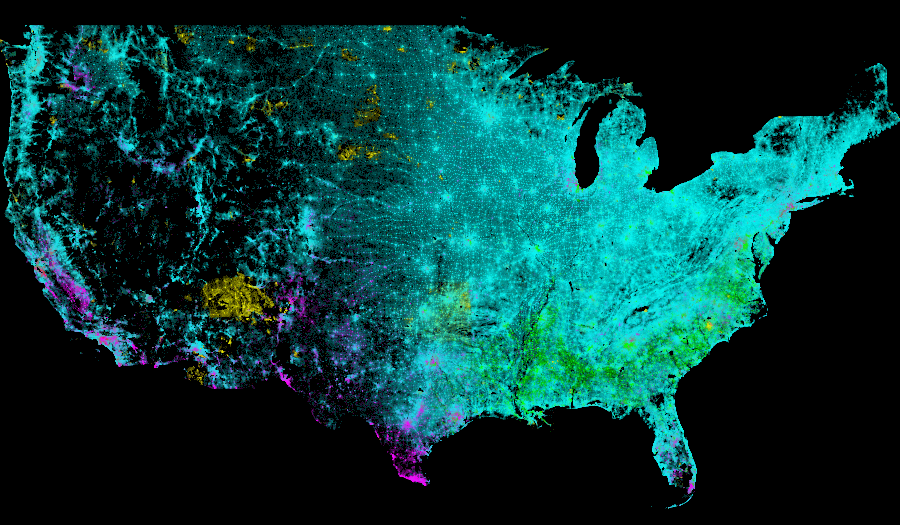

In [10]:
%%time
export(img,"Zoom 0 - USA")